# Optimal Portfoilio Selection

Project on course "Optimization Methods"

Oleg Gorodnitskii, Dmytro Fedoriaka, Rasul Khasianov

Skoltech, 2017

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime
import cvxpy as cvx

In [2]:
# Name of train/test dataset. 'data', 'nyse_each_50','nyse_each_10' or 'nyse'
DATASET_NAME = 'data'

# Period, on which we will invest.
PERIOD = 50

# Set of lambda parameters, which we will check.
LAMBDA_RANGE = [0.001, 0.01, 0.1, 1, 10]

In [3]:
data_folder = os.path.join(os.path.dirname(os.getcwd()), 'data')
train_file = os.path.join(data_folder, DATASET_NAME + '_train.csv')
test_file = os.path.join(data_folder, DATASET_NAME + '_test.csv')

In [4]:
# Reading data.
data = pd.read_csv(train_file)

In [5]:
# Extract prices and dates.

sequrity_ids = data.columns[1:]
dates = [datetime.strptime(d, '%Y-%m-%d') for d in data['Date']]
prices = np.array(data[sequrity_ids]).T

# Covariation matrix.
cov = np.corrcoef(prices)

# Number of sequrities.
N = len(sequrity_ids)

# Number of time moments in train data.
T = len(dates)

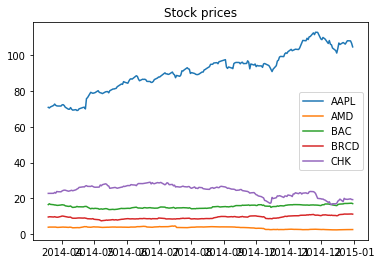

In [6]:
# Visualize some prices.

seq_to_show = sequrity_ids[:5]

for seq in seq_to_show:
    plt.plot(dates[-200:], data[seq][-200:], label = seq)
plt.legend()
plt.title("Stock prices")
plt.show()

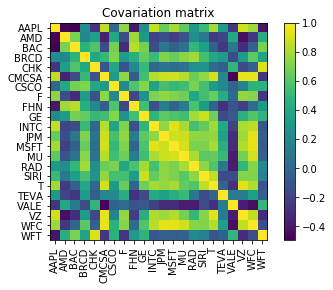

In [7]:
# Visualize covariation matrix.

plt.imshow(cov, interpolation='none')
plt.colorbar()
plt.xticks(range(len(sequrity_ids)), sequrity_ids, fontsize=10,rotation='vertical')
plt.yticks(range(len(sequrity_ids)), sequrity_ids, fontsize=10,rotation='horizontal')
plt.title("Covariation matrix")
plt.show()

First of all, let's build prediction with ARIMA.

In [8]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt


def test_stationarity(timeseries):
   
    dftest = adfuller(timeseries, autolag='AIC')
    return (dftest[0], dftest[4]['5%'])

def stationarize(timeseries):
    timeseries_log = np.log(timeseries)
    timeseries_log_diff = timeseries_log - timeseries_log.shift()
    timeseries_log_diff.dropna(inplace=True)
    return timeseries_log_diff

def check_stationarity(data):
    for sym in list(data):
        print(test_stationarity(stationarize(data[sym])))
        
    
def predict_on_period(timeseries, period):
    model = ARIMA(timeseries, order=(2, 1, 1))  
    results_ARIMA = model.fit(disp=-1) 
    forecasts = results_ARIMA.forecast(period)
    return forecasts[0]

def pred_arima(data, period):
    
    prices_pred = []
    for sym in list(data):
        timeseries_stat = stationarize(data[sym])
        prices_pred.append(np.sum(predict_on_period(timeseries_stat, period))+np.log(data[sym][-1]))
    
    return np.exp(prices_pred)


def to_ts(data):
    data['Date'] = pd.to_datetime(data['Date'], format = '%Y-%m-%d')
    data_indx = data.set_index('Date')
    return data_indx

In [9]:
# This suppresses warnings.
import warnings
warnings.simplefilter('ignore')

In [10]:
predictions = pred_arima(to_ts(data), PERIOD)
print(predictions)

[ 111.19466512    2.47545945   18.33782156   12.10888375   19.05692226
   28.12787588   26.76860785   13.26921197   13.7727354    24.27422321
   35.06773988   60.64520847   44.74958755   39.11163643    8.65865329
    3.51257124   28.91565803   54.75430045    6.62969408   40.37054358
   53.29746205   10.94925185]


lambda = 0.001000


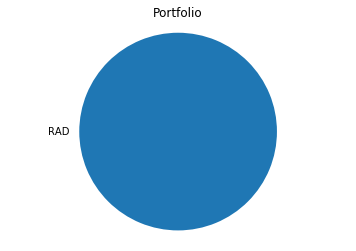

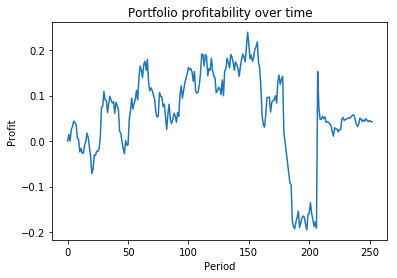

Profit on test data in 50 steps: -0.797872%
lambda = 0.010000


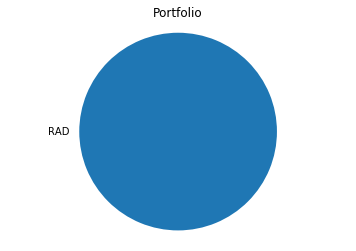

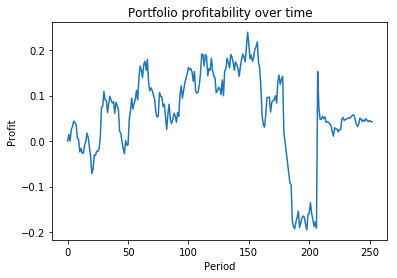

Profit on test data in 50 steps: -0.797872%
lambda = 0.100000


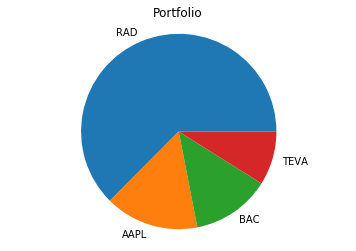

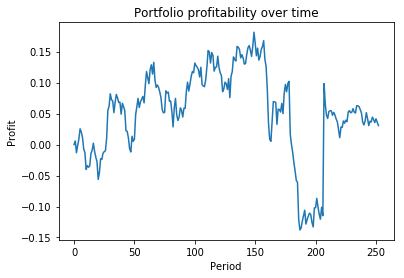

Profit on test data in 50 steps: 0.880832%
lambda = 1.000000


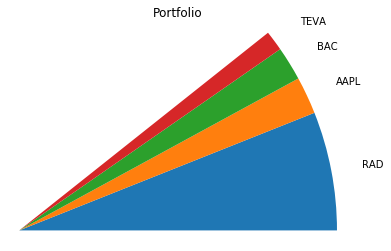

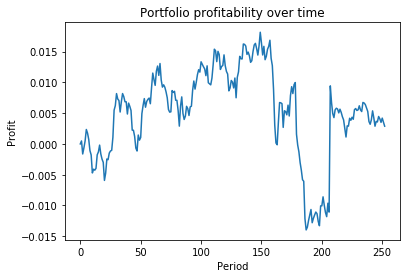

Profit on test data in 50 steps: 0.104009%
lambda = 10.000000


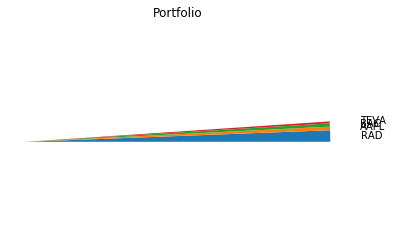

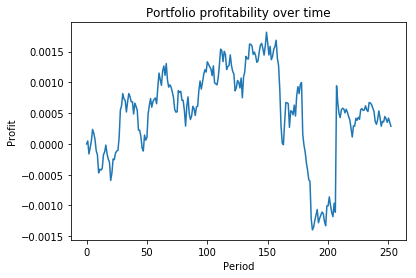

Profit on test data in 50 steps: 0.010399%


In [11]:
# Calculates profit if we buy sequrities at time_buy, sell them
# at time_sell, spend x[i] part of capital on i-rh security.
# Assumes that initial capital is equal to 1.
def count_profit(prices, date_buy, date_sell, x):    
    prices_at_buy = prices[:, date_buy]
    prices_at_sell = prices[:, date_sell]
    capital_spent = np.sum(x)
    amount_bought = x / prices_at_buy
    revenue = np.dot(amount_bought, prices_at_sell)
    return revenue - np.sum(x)

# Calculates real profit on test data.
test_prices = None
def count_real_profit(portfolio, period):
    global test_prices 
    if test_prices is None:         # This is to ensure we don't read CSV each time we count profit
        data_folder = os.path.join(os.path.dirname(os.getcwd()), 'data')
        test_data_file = os.path.join(data_folder, DATASET_NAME + '_test.csv')
        test_data = pd.read_csv(test_data_file)
        test_prices = np.array(test_data[sequrity_ids]).T
    return count_profit(test_prices, 0, period, portfolio)

# By given profitabilities, cov.matrix and lambda gives optimal portfolio.
def get_optimal_portfolio(r, cov, l):
    x = cvx.Variable(N)
    
    objective = cvx.Maximize(r*x - l*cvx.quad_form(x, cov))
    constraints = [cvx.sum_entries(x) <= 1, x >= 0]
    prob = cvx.Problem(objective, constraints)
    obj = prob.solve()
    portfolio = np.copy(np.array(x.value).reshape(-1))
    return portfolio

# prices - numpy.array (N x T) of known prices (N - number of sequritites, T - number of time moments).
# date_buy - index of row in prices, which corresponds to buying date.
# l - 'lambda' parameter in objective.
# predicted_prices - predicted/known prices on day of selling, from external predictor.
#                    Must be arranged in the same order, as columns in prices.
def get_optimal_portfoilio_for_known_predictions(prices, date_buy, l, predicted_prices):
    # Calculating profitabilities.
    r = np.array([
        (predictions[i] - prices[i, date_buy]) / prices[i, date_buy] 
        for i in range(N)
    ])
    cov = np.corrcoef(prices[:,:date_buy+1])
    return get_optimal_portfolio(r, cov, l)

def portfolio_info(portfolio, period):
    # Show portfolio as pie chart.
    inv_seq = []
    for i in range(N):
        if portfolio[i] > 1e-7:
            inv_seq.append((opt_portfolio[i], sequrity_ids[i]))
    inv_seq.sort(reverse=True)
    non_zero_inv = len(inv_seq)
    fracs = [inv_seq[i][0] for i in range(non_zero_inv)]
    labels = [inv_seq[i][1] for i in range(non_zero_inv)]
    plt.pie(fracs, labels=labels)
    plt.axis('equal')
    plt.title('Portfolio')
    plt.show()

    # Model that we invest according to portfolio now and sell sequrities later,
    # varying period between buying and selling.
    period_range = range(253)
    profits = [count_real_profit(portfolio, period) for period in period_range]
    plt.plot(period_range, profits)
    plt.xlabel("Period")
    plt.ylabel("Profit")
    plt.title('Portfolio profitability over time')
    plt.show()
    
    print("Profit on test data in %d steps: %f%%" % (period, count_real_profit(portfolio, period)*100))
    
    
for l in LAMBDA_RANGE:
    print("lambda = %f" % l)
    opt_portfolio = get_optimal_portfoilio_for_known_predictions(prices, T-1, l, predictions)
    portfolio_info(opt_portfolio, PERIOD)